In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('QVI_data.csv', parse_dates=['DATE'])

In [3]:
df['MONTH'] = df['DATE'].dt.to_period('M')

In [4]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


In [6]:
monthly_metrics = df.groupby(['STORE_NBR', 'MONTH']).agg(
    revenue = ('TOT_SALES', 'sum'),
    customers = ('LYLTY_CARD_NBR', 'nunique'),
    transactions=('LYLTY_CARD_NBR', 'count')
).reset_index()

## KEY METRICS ##
Revenue
Customers 
Average transaction per customers

In [8]:
monthly_metrics.head()


,STORE_NBR,MONTH,revenue,customers,transactions,avg_txn_per_cust
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [7]:
monthly_metrics['avg_txn_per_cust'] = monthly_metrics['transactions'] / monthly_metrics['customers']

In [9]:
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

In [18]:
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
import numpy as np

def calculate_similarity(trial_store, control_store, metric):
    trial_data = monthly_metrics[monthly_metrics['STORE_NBR'] == trial_store][metric].values
    control_data = monthly_metrics[monthly_metrics['STORE_NBR'] == control_store][metric].values

    # Ensure same length of data
    if len(trial_data) != len(control_data):
        return None

    # Pearson correlation (similarity of shape)
    corr, _ = pearsonr(trial_data, control_data)

    # Normalize magnitude similarity
    dist = euclidean(trial_data, control_data)
    max_possible = np.linalg.norm(trial_data) + np.linalg.norm(control_data)
    if max_possible == 0:
        mag_sim = 0
    else:
        mag_sim = 1 - dist / max_possible

    # Combine both metrics
    return 0.5 * corr + 0.5 * mag_sim


In [19]:
def find_best_control_store(trial_store):
    all_stores = monthly_metrics['STORE_NBR'].unique()
    all_stores = [s for s in all_stores if s != trial_store]
    
    similarities = []
    for store in all_stores:
        score = calculate_similarity(trial_store, store, 'revenue')
        if score:
            similarities.append((store, score))
    
    best = sorted(similarities, key=lambda x: x[1], reverse=True)[0]
    return best


In [16]:
trial_period = ['2019-02', '2019-03', '2019-04']

def compare_trial_vs_control(trial_store, control_store):
    trial_data = monthly_metrics[
        (monthly_metrics['STORE_NBR'] == trial_store) & 
        (monthly_metrics['MONTH'].astype(str).isin(trial_period))
    ]
    control_data = monthly_metrics[
        (monthly_metrics['STORE_NBR'] == control_store) & 
        (monthly_metrics['MONTH'].astype(str).isin(trial_period))
    ]

    print(f"Trial Store {trial_store} vs Control Store {control_store}")
    print("Revenue:")
    print(trial_data['revenue'].sum(), control_data['revenue'].sum())
    print("Customers:")
    print(trial_data['customers'].sum(), control_data['customers'].sum())
    print("Transactions per Customer:")
    print(trial_data['avg_txn_per_cust'].mean(), control_data['avg_txn_per_cust'].mean())


In [20]:
trial_stores = [77, 86, 88]
control_stores = {store: find_best_control_store(store)[0] for store in trial_stores}
print(control_stores)


{77: np.int64(41), 86: np.int64(109), 88: np.int64(201)}



Trial Store: 77 | Control Store: 41



C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: revenue_trial77_vs_control41.png


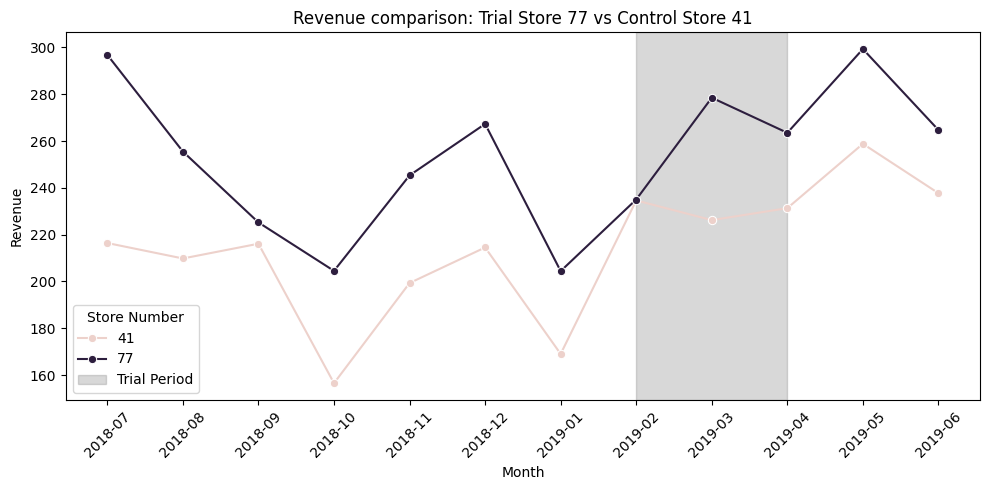

C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: customers_trial77_vs_control41.png


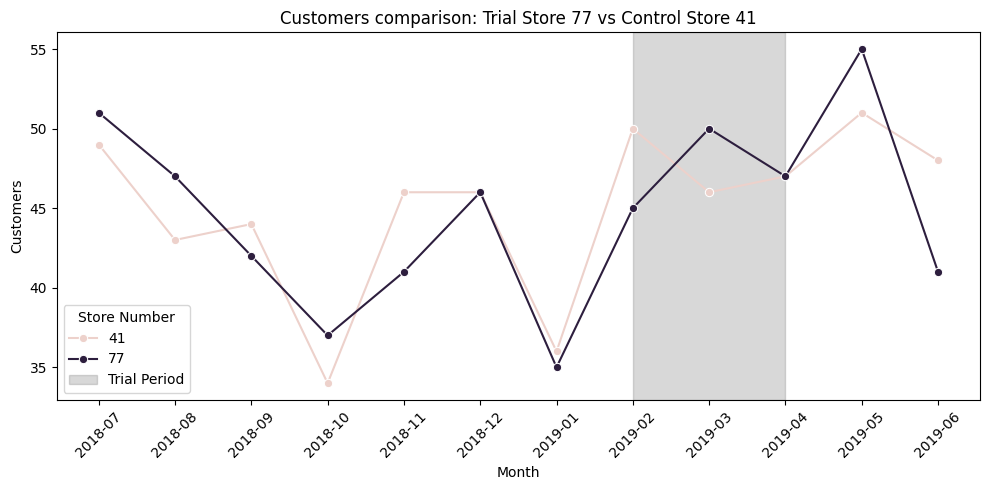

C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: avg_txn_per_cust_trial77_vs_control41.png


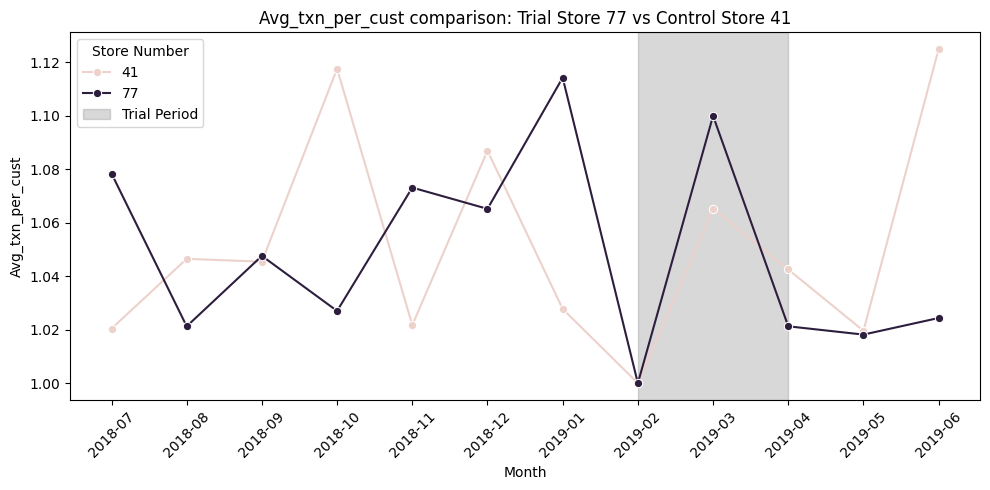


Trial Store: 86 | Control Store: 109



C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: revenue_trial86_vs_control109.png


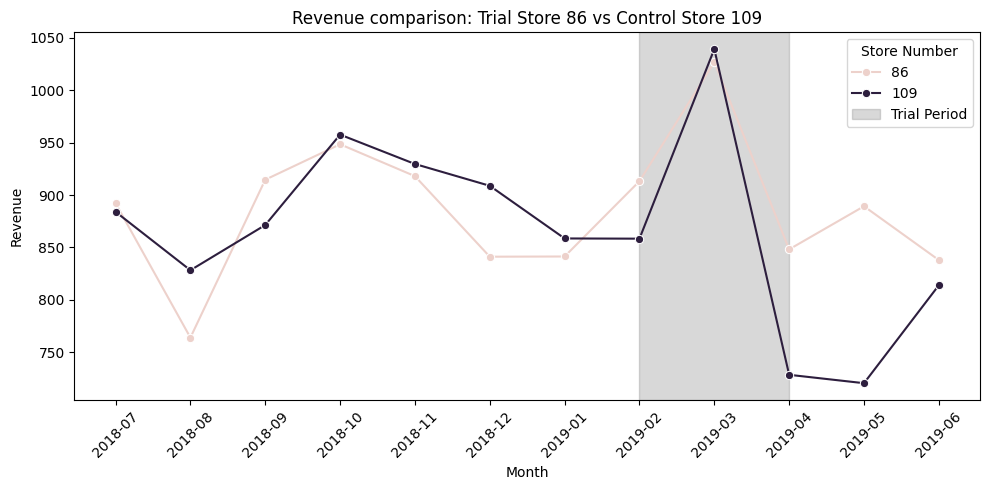

C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: customers_trial86_vs_control109.png


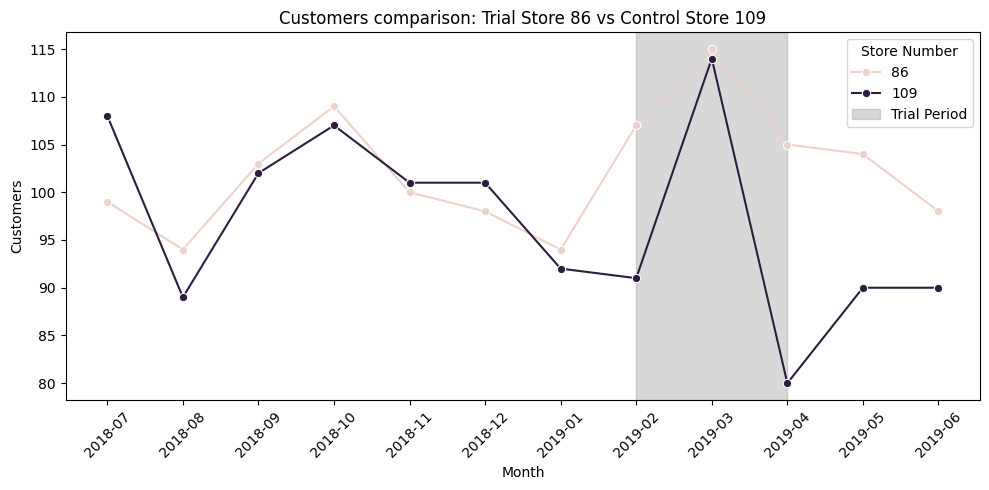

C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: avg_txn_per_cust_trial86_vs_control109.png


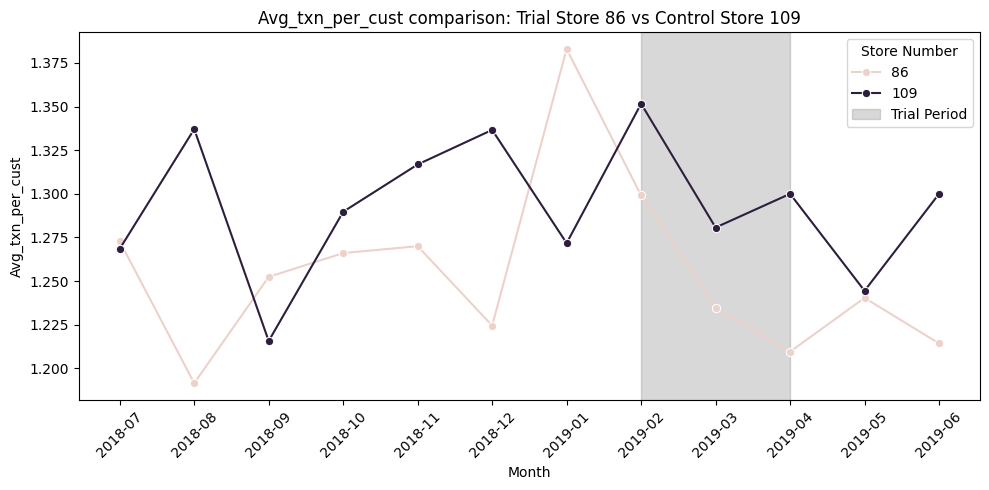


Trial Store: 88 | Control Store: 201



C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: revenue_trial88_vs_control201.png


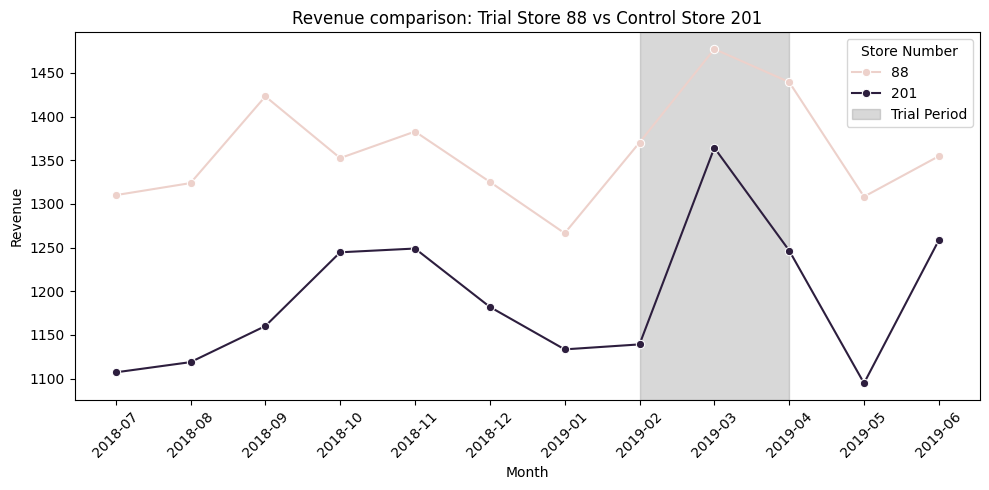

C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: customers_trial88_vs_control201.png


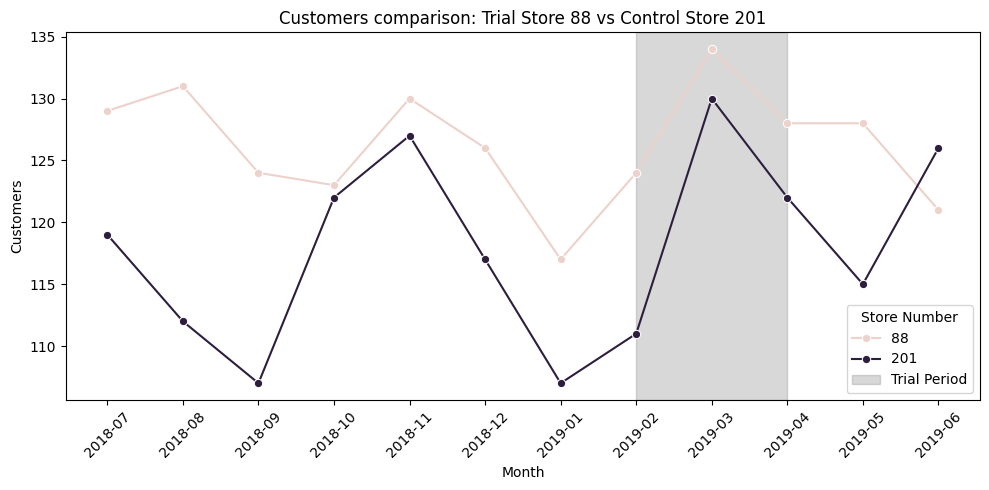

C:\Users\hetla\AppData\Local\Temp\ipykernel_5328\3745511634.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(str)


Saved plot: avg_txn_per_cust_trial88_vs_control201.png


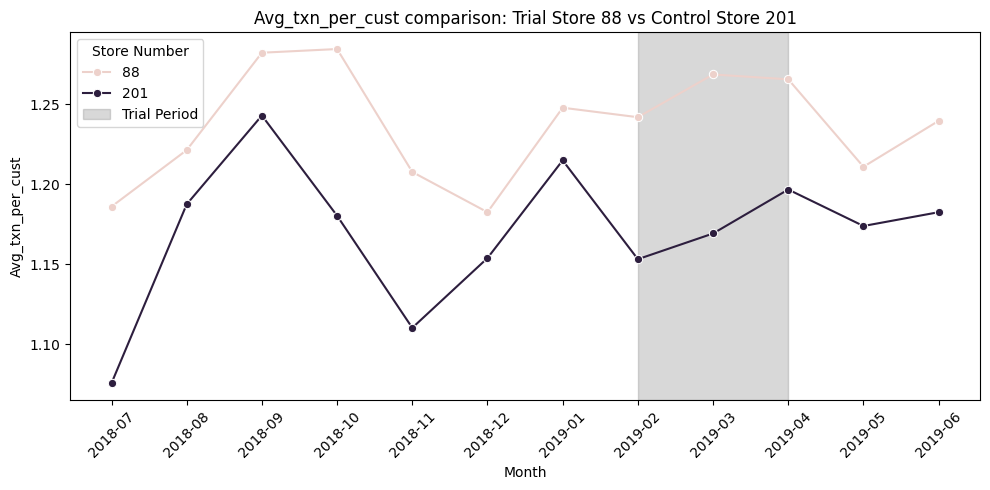

In [21]:
trial_period = ['2019-02', '2019-03', '2019-04']

for trial in trial_stores:
    control = control_stores[trial]
    print(f"\nTrial Store: {trial} | Control Store: {control}\n")
    plot_comparison(trial, control, 'revenue', trial_period)
    plot_comparison(trial, control, 'customers', trial_period)
    plot_comparison(trial, control, 'avg_txn_per_cust', trial_period)
